In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_list(lst):
    num_rows = len(lst)

    for i, word in enumerate(lst):
        ax = plt.subplot(num_rows, 1, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(word)
        
    plt.show()

In [6]:
#imagepreview
plt.figure(figsize=(20,10))
img= cv2.imread('./testimg10.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.show()

In [7]:
## LINE SEGMENTATION ##
def segment_lines(grayed_image,
                  AREA_THRESHOLD=500,
                  GAUSSIAN_BLUR_KERNEL=(5,5),
                  DILATION_KERNEL_SIZE=(7,1),
                  THRESH_NEIGHBORHOOD_SIZE=5,
                  THRESH_TUNE=5,
                  MIN_HEIGHT=10,
                  MIN_WIDTH=10):

    # Load image, grayscale, Gaussian blur, adaptive threshold
    blur = cv2.GaussianBlur(grayed_image, GAUSSIAN_BLUR_KERNEL, 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,THRESH_NEIGHBORHOOD_SIZE, THRESH_TUNE)

    # save an image to draw the lines and to extract lines from
    image_with_boxes = thresh.copy()
    image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
    image_with_boxes = cv2.bitwise_not(image_with_boxes)
    clean_image = image_with_boxes.copy()

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (DILATION_KERNEL_SIZE)) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    
    # first pass to verify line separation
    # used for line flattening
#     h_list = []
#     for c in cnts:
#         area = cv2.contourArea(c)
#         if area < AREA_THRESHOLD:
#             continue
#         x, y, w, h = cv2.boundingRect(c)
        
#         h_list.append(h)
        

    y_list = []
    lines = []
    ROI_number = 0
    good_contours = []
    for c in cnts:
        area = cv2.contourArea(c)
        
        # only draws boxes around blobs with a certain area
        if area < AREA_THRESHOLD:
            continue
            
        x,y,w,h = cv2.boundingRect(c)
        
        # minimum ratio - want horizontal boxes
        if h > 2 * w:
            continue
            
        if w < MIN_WIDTH or h < MIN_HEIGHT:
            continue
            
        good_contours.append(c)
            
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) 
        ROI = clean_image[y:y+h, x:x+w]
        y_list.append(y)
        lines.append(ROI)
        # cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
        # ROI_number += 1

    ordered_list = []
        
    y_list = np.asarray(y_list)
    for i in range(len(lines)):
        minYIndex = np.argmin(y_list)
        ordered_list.append(lines[minYIndex])
        y_list[minYIndex] = 10000
        
    return ordered_list, thresh, dilate, image_with_boxes, good_contours


In [8]:
# this doesn't work super well and is not being used
def line_flatten(img):
    flatten = np.sum(img, axis=1)
    max_sum = max(flatten)
    flatten = np.where(flatten > 0.025*max_sum, 255, 0) # tune the factor
    
    flatten = np.expand_dims(flatten, 1)
    flatten = np.repeat(flatten, 20, axis=1)
    img = np.append(img, flatten, axis=1)
    img = cv2.bitwise_not(img)
    return img

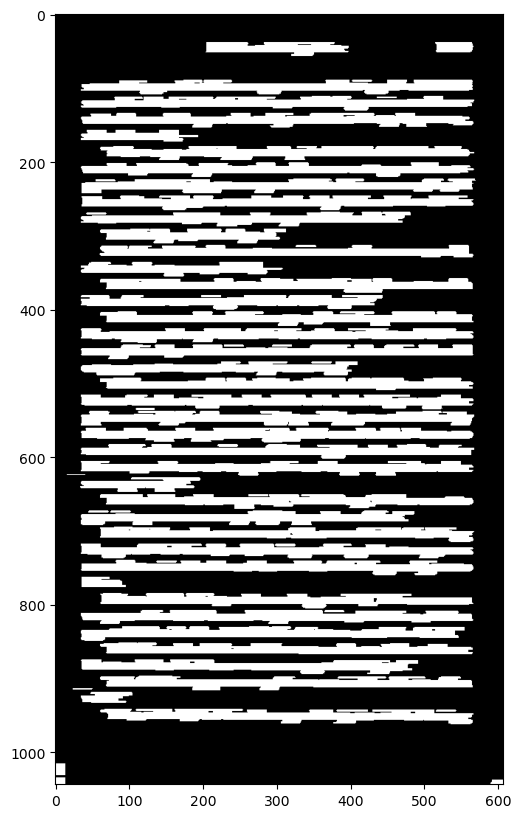

In [9]:
# preview intermediate images
lines, thresh, dilate, image_with_boxes, contours = segment_lines(img, AREA_THRESHOLD=600, THRESH_TUNE=3)
assert len(lines) == len(contours)
plt.figure(figsize=(20,10))
plt.imshow(dilate, cmap='gray') # or thresh or dilate
plt.show()

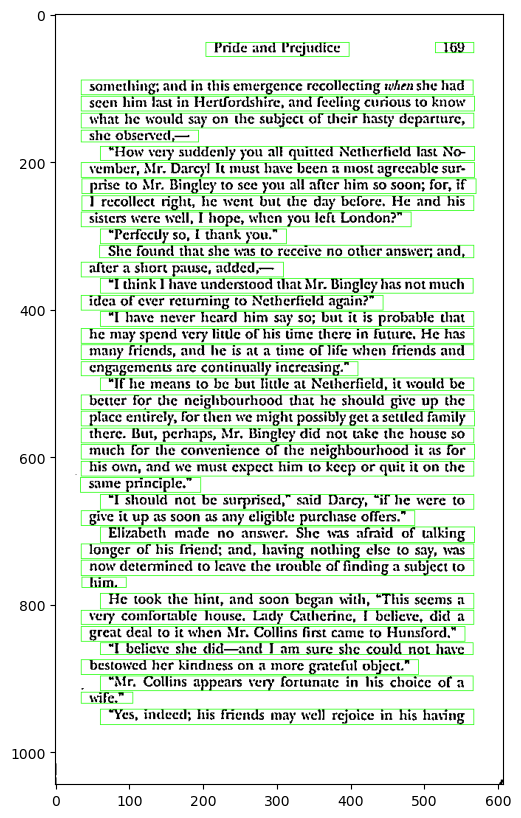

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(image_with_boxes)
plt.show()

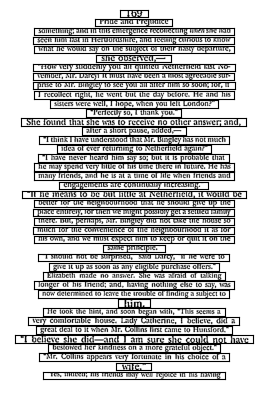

In [11]:
plot_list(lines)

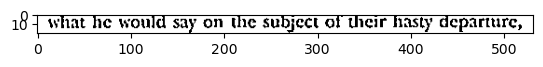

In [12]:
# single line preview
plt.imshow(lines[4])
plt.show()

In [13]:
## REPROCESS IMAGE FOR WORD GRANULARITY ##
def get_lines(grayed_image, contours,
             GAUSSIAN_BLUR_KERNEL=(3,3),
             THRESH_NEIGHBORHOOD_SIZE=3,
             THRESH_TUNE=2):
    
    y_list = []
    lines = []
    for c in contours:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        
        ROI = grayed_image[y:y+h, x:x+w]
        
        # individually blur and threshold each line
        blur = cv2.GaussianBlur(ROI, GAUSSIAN_BLUR_KERNEL, 0)
        thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,THRESH_NEIGHBORHOOD_SIZE, THRESH_TUNE)
        clean_line = cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB)
        clean_line = cv2.bitwise_not(clean_line)
        
        y_list.append(y)
        lines.append(clean_line)

    ordered_list = []
        
    y_list = np.asarray(y_list)
    for i in range(len(lines)):
        minYIndex = np.argmin(y_list)
        ordered_list.append(lines[minYIndex])
        y_list[minYIndex] = 10000
        
    return ordered_list #, blur, thresh, clean_image

In [14]:
lines = get_lines(img, contours, THRESH_NEIGHBORHOOD_SIZE=3, THRESH_TUNE=2, GAUSSIAN_BLUR_KERNEL=(3,3))

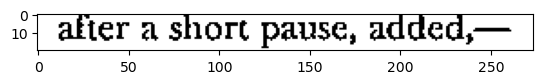

In [15]:
# single line preview
plt.imshow(lines[13])
plt.show()

In [16]:
## WORD SEGMENTING ##
def segment_words(line, WORD_AREA_THRESHOLD=1, WORD_DILATION_KERNEL_SIZE=(3, 3)):
    # example_line = img_list[5] # an arbitrary example

    # WORD_AREA_THRESHOLD = 1
    # LINE_GAUSSIAN_BLUR_KERNEL = (3, 3) # (height, width) - odd numbers # don't blur it again
    # WORD_DILATION_KERNEL_SIZE = (5, 6)  # (width, height)

    image_with_boxes = line.copy()
    gray = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)

    # blur = cv2.GaussianBlur(gray, LINE_GAUSSIAN_BLUR_KERNEL, 0) # don't blur it again
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,50) # maybe don't need to do this again either

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, WORD_DILATION_KERNEL_SIZE) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=1) # can tune the number of iterations

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    word_list = []
    x_list = []
    for c in cnts:
        area = cv2.contourArea(c)
        # maybe add an area threshold back in
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) # wtf do these args mean
        ROI = line[y:y+h, x:x+w]
        x_list.append(x)
        word_list.append(ROI)

    # for ind, x in enumerate(x_list):

    ordered_word_list = []
        
    x_list = np.asarray(x_list)
    for i in range(len(word_list)):
        minXIndex = np.argmin(x_list)
        ordered_word_list.append(word_list[minXIndex])
        x_list[minXIndex] = 10000
        

    
    return ordered_word_list, thresh, image_with_boxes

In [17]:
# # preview intermediate results
# plt.imshow(dilate, cmap='gray')
# plt.show()

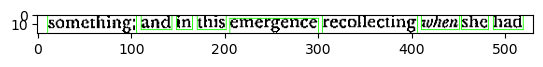

In [18]:
word_list, thresh, image_with_boxes = segment_words(lines[2])

plt.imshow(image_with_boxes)
plt.show()

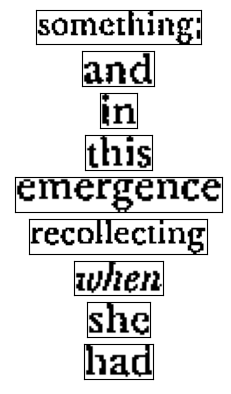

In [19]:
plot_list(word_list)

In [66]:
# example_line = img_list[5]
def separateLetters(image):
    WORD_AREA_THRESHOLD = 3
    WORD_GAUSSIAN_BLUR_KERNEL = (3, 5) # (height, width) - odd numbers
    WORD_DILATION_KERNEL_SIZE = (1, 3)  # (width, height)

    image_with_boxes = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, WORD_GAUSSIAN_BLUR_KERNEL, 0) # don't blur it again
    thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, WORD_DILATION_KERNEL_SIZE) # generates rectangular kernel of the given size
    dilate = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    char_list = []
    x_list = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < WORD_AREA_THRESHOLD:
            continue
        # maybe add an area threshold back in
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (36,255,12), 1) # wtf do these args mean
        ROI = image[y:y+h, x:x+w]
        shape = ROI.shape
        print(shape)
        if shape[0] < 25 or shape[1] < 25:
            pad_width = (16-shape[0])//2
            print(pad_width)
            pad_height = (16-shape[1])//2
            print(pad_height)
            ROI = np.pad(ROI, ((pad_width, (16-pad_width)), (pad_height, (16-pad_height)), (0,0)), constant_values=1)
        x_list.append(x)
        char_list.append(ROI)
    
    ordered_char_list = []
        
    x_list = np.asarray(x_list)
    for i in range(len(char_list)):
        minXIndex = np.argmin(x_list)
        ordered_char_list.append(char_list[minXIndex])
        x_list[minXIndex] = 10000
    
    return ordered_char_list, thresh, image_with_boxes, dilate

(16, 10, 3)
4
7
(11, 10, 3)
7
7
(12, 8, 3)
6
8
(11, 8, 3)
7
8
(11, 9, 3)
7
8
(12, 8, 3)
6
8
(12, 8, 3)
6
8
(11, 7, 3)
7
9
(12, 5, 3)
6
10
(15, 4, 3)
5
10
(15, 4, 3)
5
10
(15, 4, 3)
5
10


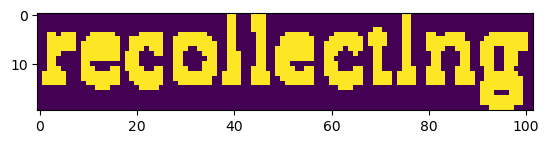

In [67]:
# what is going on here??
letter_list, thresh, image_with_boxes, dilate = separateLetters(word_list[5])

plt.figure()
num_rows = len(letter_list)

# for letter in letter_list:
#     plt.subplot(num_rows, 1, i+1)
#     plt.imshow(letter)
    
plt.imshow(dilate)
plt.show()

TypeError: Invalid shape (27, 23, 19) for image data

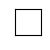

In [68]:
plot_list(letter_list)
print(letter_list[4].shape)